In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymatreader import read_mat
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d
from scipy.signal import hilbert, windows
import scipy.ndimage

## 파일 불러오기

In [ ]:
my_arm_img_arr = np.load('data/id/arm_Img.npy')
print(my_arm_img_arr[0])
print(my_arm_img_arr.shape)

[[[ 85913.03753208  24819.52877966  71957.61596581 ...  34360.15191981
    50272.98476173  78573.20051223]]

 [[ 83895.75941382  67498.9446992   49121.17119455 ... 101411.99016369
    85765.80496352  56251.5551138 ]]

 [[100416.83781826  47937.58574978  48423.17230521 ...  30848.34434693
   100192.58799333 119290.20167041]]

 ...

 [[ 73597.7538495   86581.26183538  93052.30248452 ...  36350.72781553
    25305.69677963  53825.01245149]]

 [[ 51534.31415886  57159.91165351  71718.78329985 ...  21151.89928724
    30086.43476329  34017.04436316]]

 [[ 29186.22354748  28129.74216262  66049.23114292 ...  59301.82175486
    62889.9084236   45496.61317807]]]
(374, 128, 1, 100)


## 내 팔의 결과 이미지 부터 확인하기

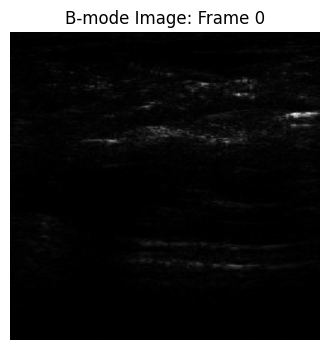

In [3]:
my_arm_img0 = my_arm_img_arr[:, :, 0, 0] 
plt.figure(figsize=(4, 4))
plt.imshow(my_arm_img0, cmap='gray', aspect='auto', origin='upper')
plt.title('B-mode Image: Frame 0')
plt.xlabel('Depth Samples')
plt.ylabel('Elements')
plt.axis('off')
plt.show()

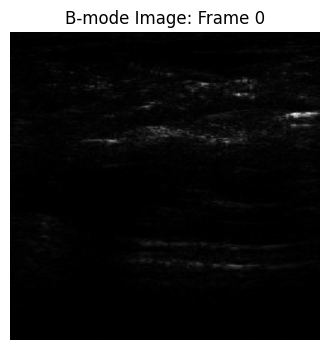

In [ ]:
my_arm_frames = my_arm_img_arr[:, :, 0, :]
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(my_arm_frames[:,:,0], cmap='gray', aspect='auto', origin='upper')
ax.axis('off')
def update_frame(i):
    im.set_data(my_arm_frames[:,:,i])
    ax.set_title(f'B-mode Image: Frame {i}')
    return im,
ani = FuncAnimation(fig, update_frame, frames=my_arm_frames.shape[2], interval=100, blit=True)
plt.show()
ani.save('arm_animation150.mp4', writer='ffmpeg', fps=150)

In [ ]:
my_arm_rdata = np.load('data/id/arm_rfdata.npy')
print(my_arm_rdata[0])
print(my_arm_rdata.shape)

[[-10  -9 -10 ...  -8 -11  -9]
 [-50 -49 -51 ... -48 -50 -48]
 [-31 -33 -35 ... -33 -31 -32]
 ...
 [-37 -38 -38 ... -38 -37 -36]
 [ 25  25  27 ...  26  24  28]
 [  0  -1  -2 ...  -1  -1   1]]
(2176, 128, 500)


## arm의 Raw Data Processing

In [5]:
# m으로 통일 시키기 speed of sound가 m/s이므로 
trans_element = 128
#DAS 목표
col_pixels = 128
row_pixels = 2000# >1600 pixels, 40mm/2000 = 0.02mm
col_spacing = (3.84/col_pixels) * 0.01
row_spacing = (4.0/row_pixels) * 0.01

In [6]:
print(col_spacing)
print(row_spacing)

0.0003
2e-05


In [7]:
delay = np.zeros((row_pixels, col_pixels, trans_element), dtype=np.float32)
x_e = (np.arange(trans_element)-(trans_element-1)/2)*col_spacing
x_p = (np.arange(col_pixels)-(col_pixels-1)/2)*col_spacing
z_p = np.arange(row_pixels) * row_spacing

Xe = x_e.reshape(1, 1, trans_element)   # (1,1,128)
Xp = x_p.reshape(1, col_pixels, 1)   # (1,128,1)
Zp = z_p.reshape(row_pixels, 1, 1)   # (2000,1,1)
distances = np.sqrt((Xp - Xe)**2 + Zp**2)

In [8]:
distances

array([[[0.00000000e+00, 3.00000000e-04, 6.00000000e-04, ...,
         3.75000000e-02, 3.78000000e-02, 3.81000000e-02],
        [3.00000000e-04, 0.00000000e+00, 3.00000000e-04, ...,
         3.72000000e-02, 3.75000000e-02, 3.78000000e-02],
        [6.00000000e-04, 3.00000000e-04, 0.00000000e+00, ...,
         3.69000000e-02, 3.72000000e-02, 3.75000000e-02],
        ...,
        [3.75000000e-02, 3.72000000e-02, 3.69000000e-02, ...,
         0.00000000e+00, 3.00000000e-04, 6.00000000e-04],
        [3.78000000e-02, 3.75000000e-02, 3.72000000e-02, ...,
         3.00000000e-04, 0.00000000e+00, 3.00000000e-04],
        [3.81000000e-02, 3.78000000e-02, 3.75000000e-02, ...,
         6.00000000e-04, 3.00000000e-04, 0.00000000e+00]],

       [[2.00000000e-05, 3.00665928e-04, 6.00333241e-04, ...,
         3.75000053e-02, 3.78000053e-02, 3.81000052e-02],
        [3.00665928e-04, 2.00000000e-05, 3.00665928e-04, ...,
         3.72000054e-02, 3.75000053e-02, 3.78000053e-02],
        [6.00333241e-04, 

In [9]:
c = 1540 # m/s
center_freq = 7.6e6 # Hz
samples_per_wave = 4.1
fs = center_freq * samples_per_wave

delay_rx = (distances / c) * fs

total_path = Zp + distances  
delay_tx_rx = (total_path / c) * fs

In [ ]:
n_samples, n_elements, n_frames = my_arm_rdata.shape

beamformed = np.zeros((row_pixels, col_pixels, n_frames), dtype=np.float32)

sample_idx = np.arange(n_samples)    # [0, 1, …, n_samples-1]

theta = np.deg2rad(30)
max_lateral = z_p / np.cos(theta/2)
mask = distances <= max_lateral[:,None,None]

w = windows.hann(n_elements, sym=False)
for f in range(n_frames):
    for e in range(n_elements):
        sig = my_arm_rdata[:, e, f] 
        ds = delay_tx_rx[:, :, e]
        interp_func = interp1d(
            sample_idx, sig,
            kind='linear',
            bounds_error=False,
            fill_value=0.0
        )
        delayed = interp_func(ds) 
        delayed[~mask[:,:,e]] = 0
        beamformed[:,:,f] += delayed * w[e]

In [12]:
beamformed

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.01135946e-02, -2.95113232e-02, -3.07158660e-02, ...,
         -2.89090518e-02, -3.01135946e-02, -2.89090518e-02],
        [-7.46367350e-02, -7.94520080e-02, -8.42672810e-02, ...,
         -7.94520080e-02, -7.46367350e-02, -7.70443752e-02],
        ...,
        [-2.00234562e-01, -2.05646306e-01, -2.05646306e-01, ...,
         -2.05646306e-01, -2.00234562e-01, -1.94822818e-01],
        [ 6.01909161e-02,  6.01909161e-02,  6.50061890e-02, ...,
          6.25985563e-02,  5.77832796e-02,  6.74138293e-02],
        [ 0.00000000e+00, -6.02271874e-04, -1.20454375e-03, ...,
         -6.02271874e-04, -6.02271874e-04,  6.02271874e-04]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.57119681e-02, -4.65720445e-02, -4.77765873e-02, ...,
         -4.69446704e-02, -4.61994186e

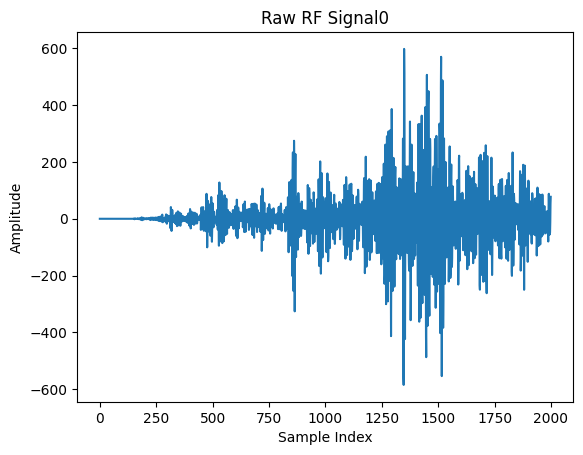

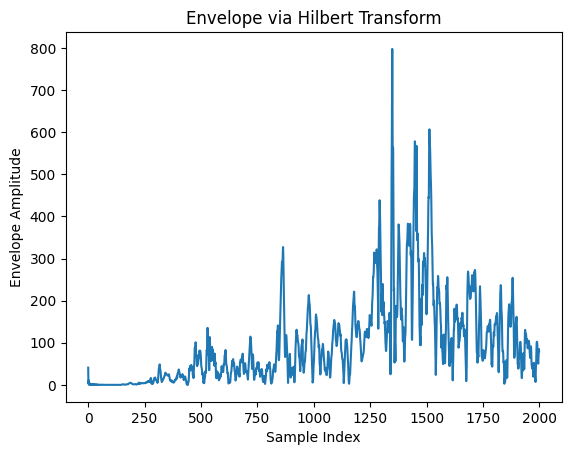

In [ ]:
sig = beamformed[:, 0, 0]
analytic_sig = hilbert(sig, axis = 0)
envelope0 = np.abs(analytic_sig)

plt.figure()
plt.plot(sig)
plt.title('Raw RF Signal0')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

plt.figure()
plt.plot(envelope0)
plt.title('Envelope via Hilbert Transform')
plt.xlabel('Sample Index')
plt.ylabel('Envelope Amplitude')
plt.show()

In [ ]:
envelope = np.abs(hilbert(beamformed, axis=0)) 

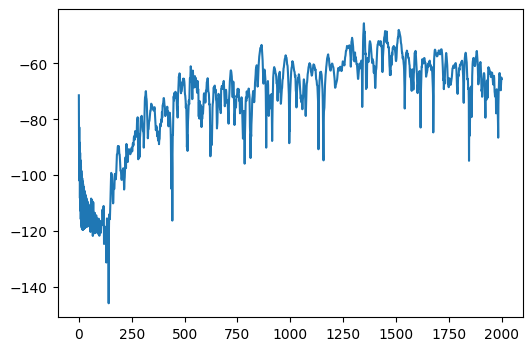

In [15]:
env0 = envelope[:, :, 0]
env_db = 20*np.log10(env0/np.max(env0)+1e-12)

plt.figure(figsize=(6, 4))
plt.plot(env_db[:,0])
plt.show()

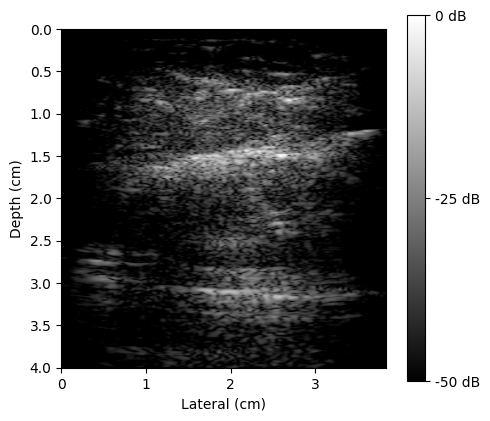

In [ ]:
env_db_clipped = np.clip(env_db, -50, 0)
bmode_400 = scipy.ndimage.zoom(env_db_clipped,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_400, cmap='gray', vmin=-50, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB','-25 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

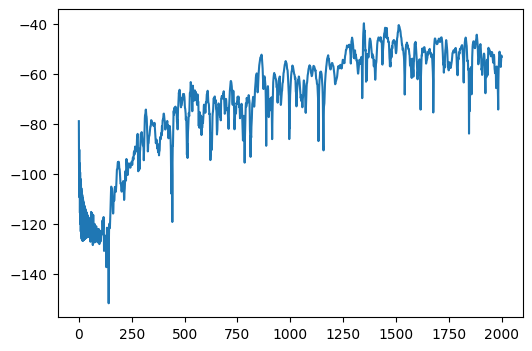

In [17]:
#TGC 고려
Gmax_db = 20
gain_db = np.linspace(0, Gmax_db, row_pixels)
gain_linear= 10**(gain_db/20)
envelope_tgc = envelope * gain_linear[:, None, None]

envtgc = envelope_tgc[:, :, 0]
env_dbt = 20*np.log10(envtgc/np.max(envtgc)+1e-12)

plt.figure(figsize=(6, 4))
plt.plot(env_dbt[:,0])
plt.show()

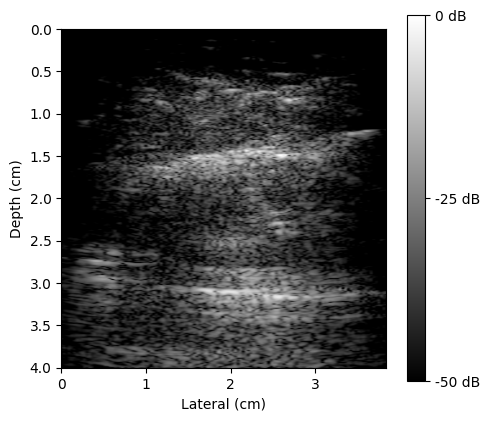

In [ ]:
env_cli_tgc = np.clip(env_dbt, -50, 0)
bmode_tgc = scipy.ndimage.zoom(env_cli_tgc,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_tgc, cmap='gray', vmin=-50, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB','-25 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

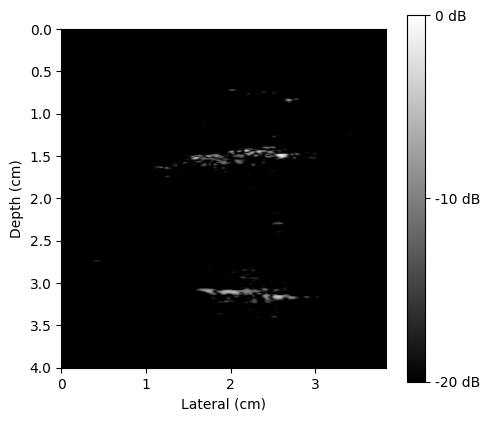

In [ ]:
env_cli_tgc = np.clip(env_dbt, -20, 0)
bmode_tgc = scipy.ndimage.zoom(env_cli_tgc,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_tgc, cmap='gray',vmin=-20, vmax=0, origin='upper',extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-20, -10, 0])
cbar.set_ticklabels(['-20 dB','-10 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()

# CF적용

In [23]:
my_arm_rdata[0]

array([[-10,  -9, -10, ...,  -8, -11,  -9],
       [-50, -49, -51, ..., -48, -50, -48],
       [-31, -33, -35, ..., -33, -31, -32],
       ...,
       [-37, -38, -38, ..., -38, -37, -36],
       [ 25,  25,  27, ...,  26,  24,  28],
       [  0,  -1,  -2, ...,  -1,  -1,   1]], dtype=int16)

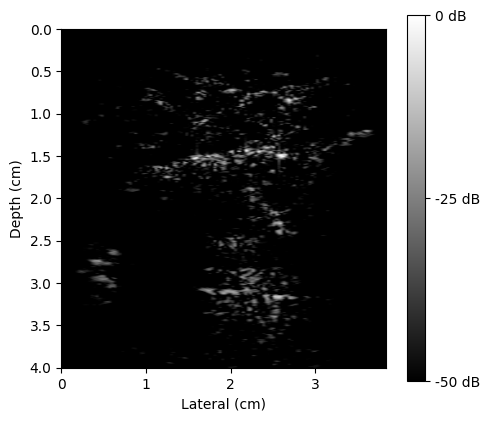

In [ ]:
n_samples, n_elements, n_frames = my_arm_rdata.shape
beamformed_cf = np.zeros((row_pixels, col_pixels, n_frames), dtype=np.float32)
sample_idx = np.arange(n_samples)
theta = np.deg2rad(30)
max_lateral = z_p / np.cos(theta/2)
mask = distances <= max_lateral[:, None, None]
w = windows.hann(n_elements, sym=False)

for f in range(n_frames):
    signals = np.zeros((row_pixels, col_pixels, n_elements), dtype=np.float32)
    
    for e in range(n_elements):
        sig = my_arm_rdata[:, e, f] 
        ds = delay_tx_rx[:, :, e]
        interp_fn = interp1d(sample_idx, sig, kind='linear', bounds_error=False, fill_value=0.0)
        delayed = interp_fn(ds) 
        delayed[~mask[:, :, e]] = 0 
        signals[:, :, e] = delayed * w[e]
    
    sum_sig = np.sum(signals, axis=2) 
    abs_sum2 = np.abs(sum_sig)**2 

    sum_sq = np.sum(np.abs(signals)**2, axis=2) 

    L = 0
    M = signals.shape[2]
    cf = abs_sum2 / (M * sum_sq + 1e-12)   
    norm = 1.0 / (M -L + 1)   
    y_sum = sum_sig * norm 
    beamformed_cf[:,:,f] = y_sum * cf
    beamformed_cf[:, :, f] = sum_sig * cf
    
envelope_cf = np.abs(hilbert(beamformed_cf, axis=0))
env0cf = envelope_cf[:, :, 0]
env_dbcf = 20*np.log10(env0cf/np.max(env0cf)+1e-12)

env_cli_cf = np.clip(env_dbcf, -50, 0)
bmode_cf = scipy.ndimage.zoom(env_cli_cf,(400/row_pixels, 400/col_pixels))

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(bmode_cf, cmap='gray',vmin=-50, vmax=0, origin='upper', extent=[0, 3.84, 4.00, 0])
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
cbar.set_ticks([-50, -25, 0])
cbar.set_ticklabels(['-50 dB','-25 dB','0 dB'])
ax.set_xlabel('Lateral (cm)')
ax.set_ylabel('Depth (cm)')
plt.tight_layout()
plt.show()